In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

data_2005 = pd.read_csv('2005.csv')
data_2006 = pd.read_csv('2006.csv')
data_2007 = pd.read_csv('2007.csv')

# Définition des variables globales



In [47]:
RISK_PREMIUM_RATIO = 0.1
TRANSITION_PROBABILITY = 0.05
SIGMA = 0.1
data_2005

,Household_ID,Claim_Amount
0,1,0
1,2,0
2,3,0
3,3,0
4,4,0
5,5,0
6,5,0
7,5,0
8,6,0
9,6,0


# Traitement des données de l'année 2005 pour estimer le prix en 2006. 

### le prix juste de 2006 est calculé à partir de l'année 2005 et les valeurs sont donc martigales. 
### comme le prix juste est martingale, il doit neutraliser la perte.

In [31]:
p = data_2005['Claim_Amount'].sum()/len(data_2005['Claim_Amount'])

In [32]:
claim_ratio_2005 = len(data_2005[data_2005['Claim_Amount']>0])/len(data_2005['Claim_Amount'])
average_severity_2005 = data_2005['Claim_Amount'].sum()/len(data_2005[data_2005['Claim_Amount']>0])

### L'estimation de big data permet d'identifier la perte potentielle par client, donc, le prix juste égale à la perte estimée.

### Ici, on n'utilise pas le méthode d'apprentissage pour estimer les perte future, mais on suppose que la perte future est connue et on estime la prédiction. 

On a, par hypothèse:

$perte\ réelle_i = perte\ estimée_i \times v_i$

pour créer des données positives pour la prédiction, on suppose:

si $i$ est un individu qui n'a pas d'accident en 2016:

$ perte\ estimée_i = (perte\ réelle_i + transition\ probability \times perte\ moyenne) \times w_i $

sinon :

$ perte\ estimée_i = (perte\ réelle_i - transition\ probability' \times perte\ moyenne) \times w_i$

In [33]:
claim_ratio = len(data_2006[data_2006['Claim_Amount']>0])/len(data_2006['Claim_Amount'])
average_severity = data_2006['Claim_Amount'].sum()/len(data_2006[data_2006['Claim_Amount']>0])

TRANSITION_PROBABILITY_NONNULL = TRANSITION_PROBABILITY/claim_ratio
TRANSITION_PROBABILITY_NONNULL

7.017560744714421

In [34]:


predicted = []
for element in data_2006['Claim_Amount']:
    w = np.random.lognormal(0,SIGMA,1)
    if element == 0:
        predicted.append(TRANSITION_PROBABILITY*average_severity*w)
    else:
        predicted.append(np.abs(element-TRANSITION_PROBABILITY_NONNULL*average_severity)*w)

In [35]:
sum(predicted), sum(data_2006['Claim_Amount'])

(array([ 84685757.02485247]), 6363995.1437135413)

# Comparaison des données estimées et les données réelles

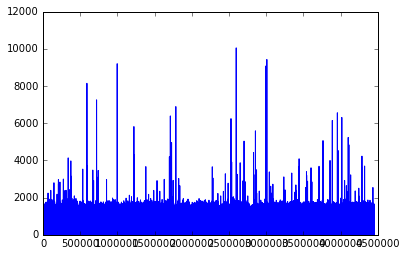

In [36]:
plt.plot(predicted)

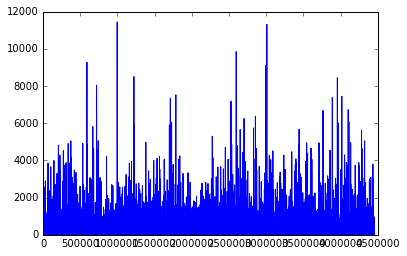

In [37]:
plt.plot(data_2006['Claim_Amount'])

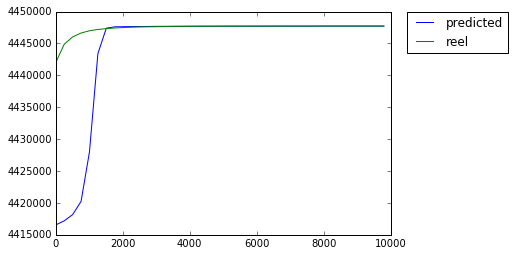

In [38]:
values, base = np.histogram(predicted, bins=40)
values2, base2 = np.histogram(data_2006['Claim_Amount'], bins=40)
cumulative = np.cumsum(values)
cumulative2 = np.cumsum(values2)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue',label = 'predicted')
#plot the survival function
plt.plot(base[:-1], cumulative2, c='green',label = 'reel')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Payement Historique

In [39]:
MAX_HOUSEHOLD = np.max([np.max(data_2005['Household_ID']),np.max(data_2006['Household_ID']),np.max(data_2007['Household_ID'])])
historical_payment = [0]*(MAX_HOUSEHOLD+1)

i=0
for element in data_2005['Claim_Amount']:
    if element != 0:
        historical_payment[data_2005['Household_ID'][i]]+=element
    i=i+1


# Pricing et matching

In [40]:
from IPython.display import clear_output
prices = []
policy_type = []
policy_number = len(data_2006['Household_ID'])
for i in range(policy_number):
    non_big_data_price = p + historical_payment[data_2006['Household_ID'][i]] * RISK_PREMIUM_RATIO
    big_data_price = predicted[i]
    if big_data_price > non_big_data_price:
        policy_type.append(0)
    else: policy_type.append(1)
    prices.append(np.min((non_big_data_price,big_data_price)))
    if i%100000 ==0:
        clear_output()
        print('{}% finished'.format(i*100/policy_number))
clear_output()
print('finished')


finished


# Profit de fin d'année

In [41]:
big_data_profit = 0
non_big_data_profit = 0

for i in range(policy_number):
    if policy_type[i] == 0:
        non_big_data_profit += (prices[i]-data_2006['Claim_Amount'][i])
    else:
        big_data_profit += (prices[i]-data_2006['Claim_Amount'][i])

In [42]:
non_big_data_profit

127439.83251822181

In [43]:
big_data_profit

38740.847664755674

# Estimation de profit s'il n'y a pas de Big Data

In [44]:
non_big_data_price_contrast = []
for i in range(policy_number):
    non_big_data_price_contrast += [p + historical_payment[data_2006['Household_ID'][i]] * RISK_PREMIUM_RATIO]
    
non_big_data_profit_contrast = np.sum(non_big_data_price_contrast)-np.sum(data_2006['Claim_Amount'])

In [45]:
non_big_data_profit_contrast

338901.02022767253

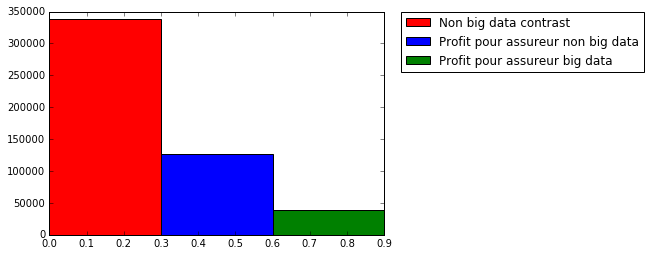

In [46]:
bar_width = 0.3
plt.bar(left = 0, height = non_big_data_profit_contrast,width=bar_width,color = 'red',label = 'Non big data contrast')
plt.bar(left = bar_width, height = non_big_data_profit,width= bar_width,label = 'Profit pour assureur non big data')
plt.bar(left = bar_width*2, height = big_data_profit,width=bar_width, color = 'green',label = 'Profit pour assureur big data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)